### **1. Import Libraries**

In [1]:
from IPython.display import clear_output
clear_output()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import os

### **2. EDA & Data Cleaning**

In [2]:
# load dataset
df = pd.read_excel('RTW DATA.xlsx')

# check columns names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SessionID       7103 non-null   object 
 1   TimeStart       7103 non-null   object 
 2   TimeStop        7077 non-null   object 
 3   ProcessBy       7103 non-null   object 
 4   ShiftID         7103 non-null   object 
 5   Product         7102 non-null   object 
 6   WeightID        7103 non-null   object 
 7   Location        7103 non-null   object 
 8   LeaderID        7103 non-null   object 
 9   Mpw             7103 non-null   int64  
 10  ProdCode        7103 non-null   object 
 11  Lot             7103 non-null   object 
 12  QtyOutput       7103 non-null   int64  
 13  Remark          7103 non-null   object 
 14  LNCNo           470 non-null    object 
 15  Plant           470 non-null    float64
 16  Department      470 non-null    object 
 17  WorkCenter      470 non-null    o

#### **2.1. EDA**

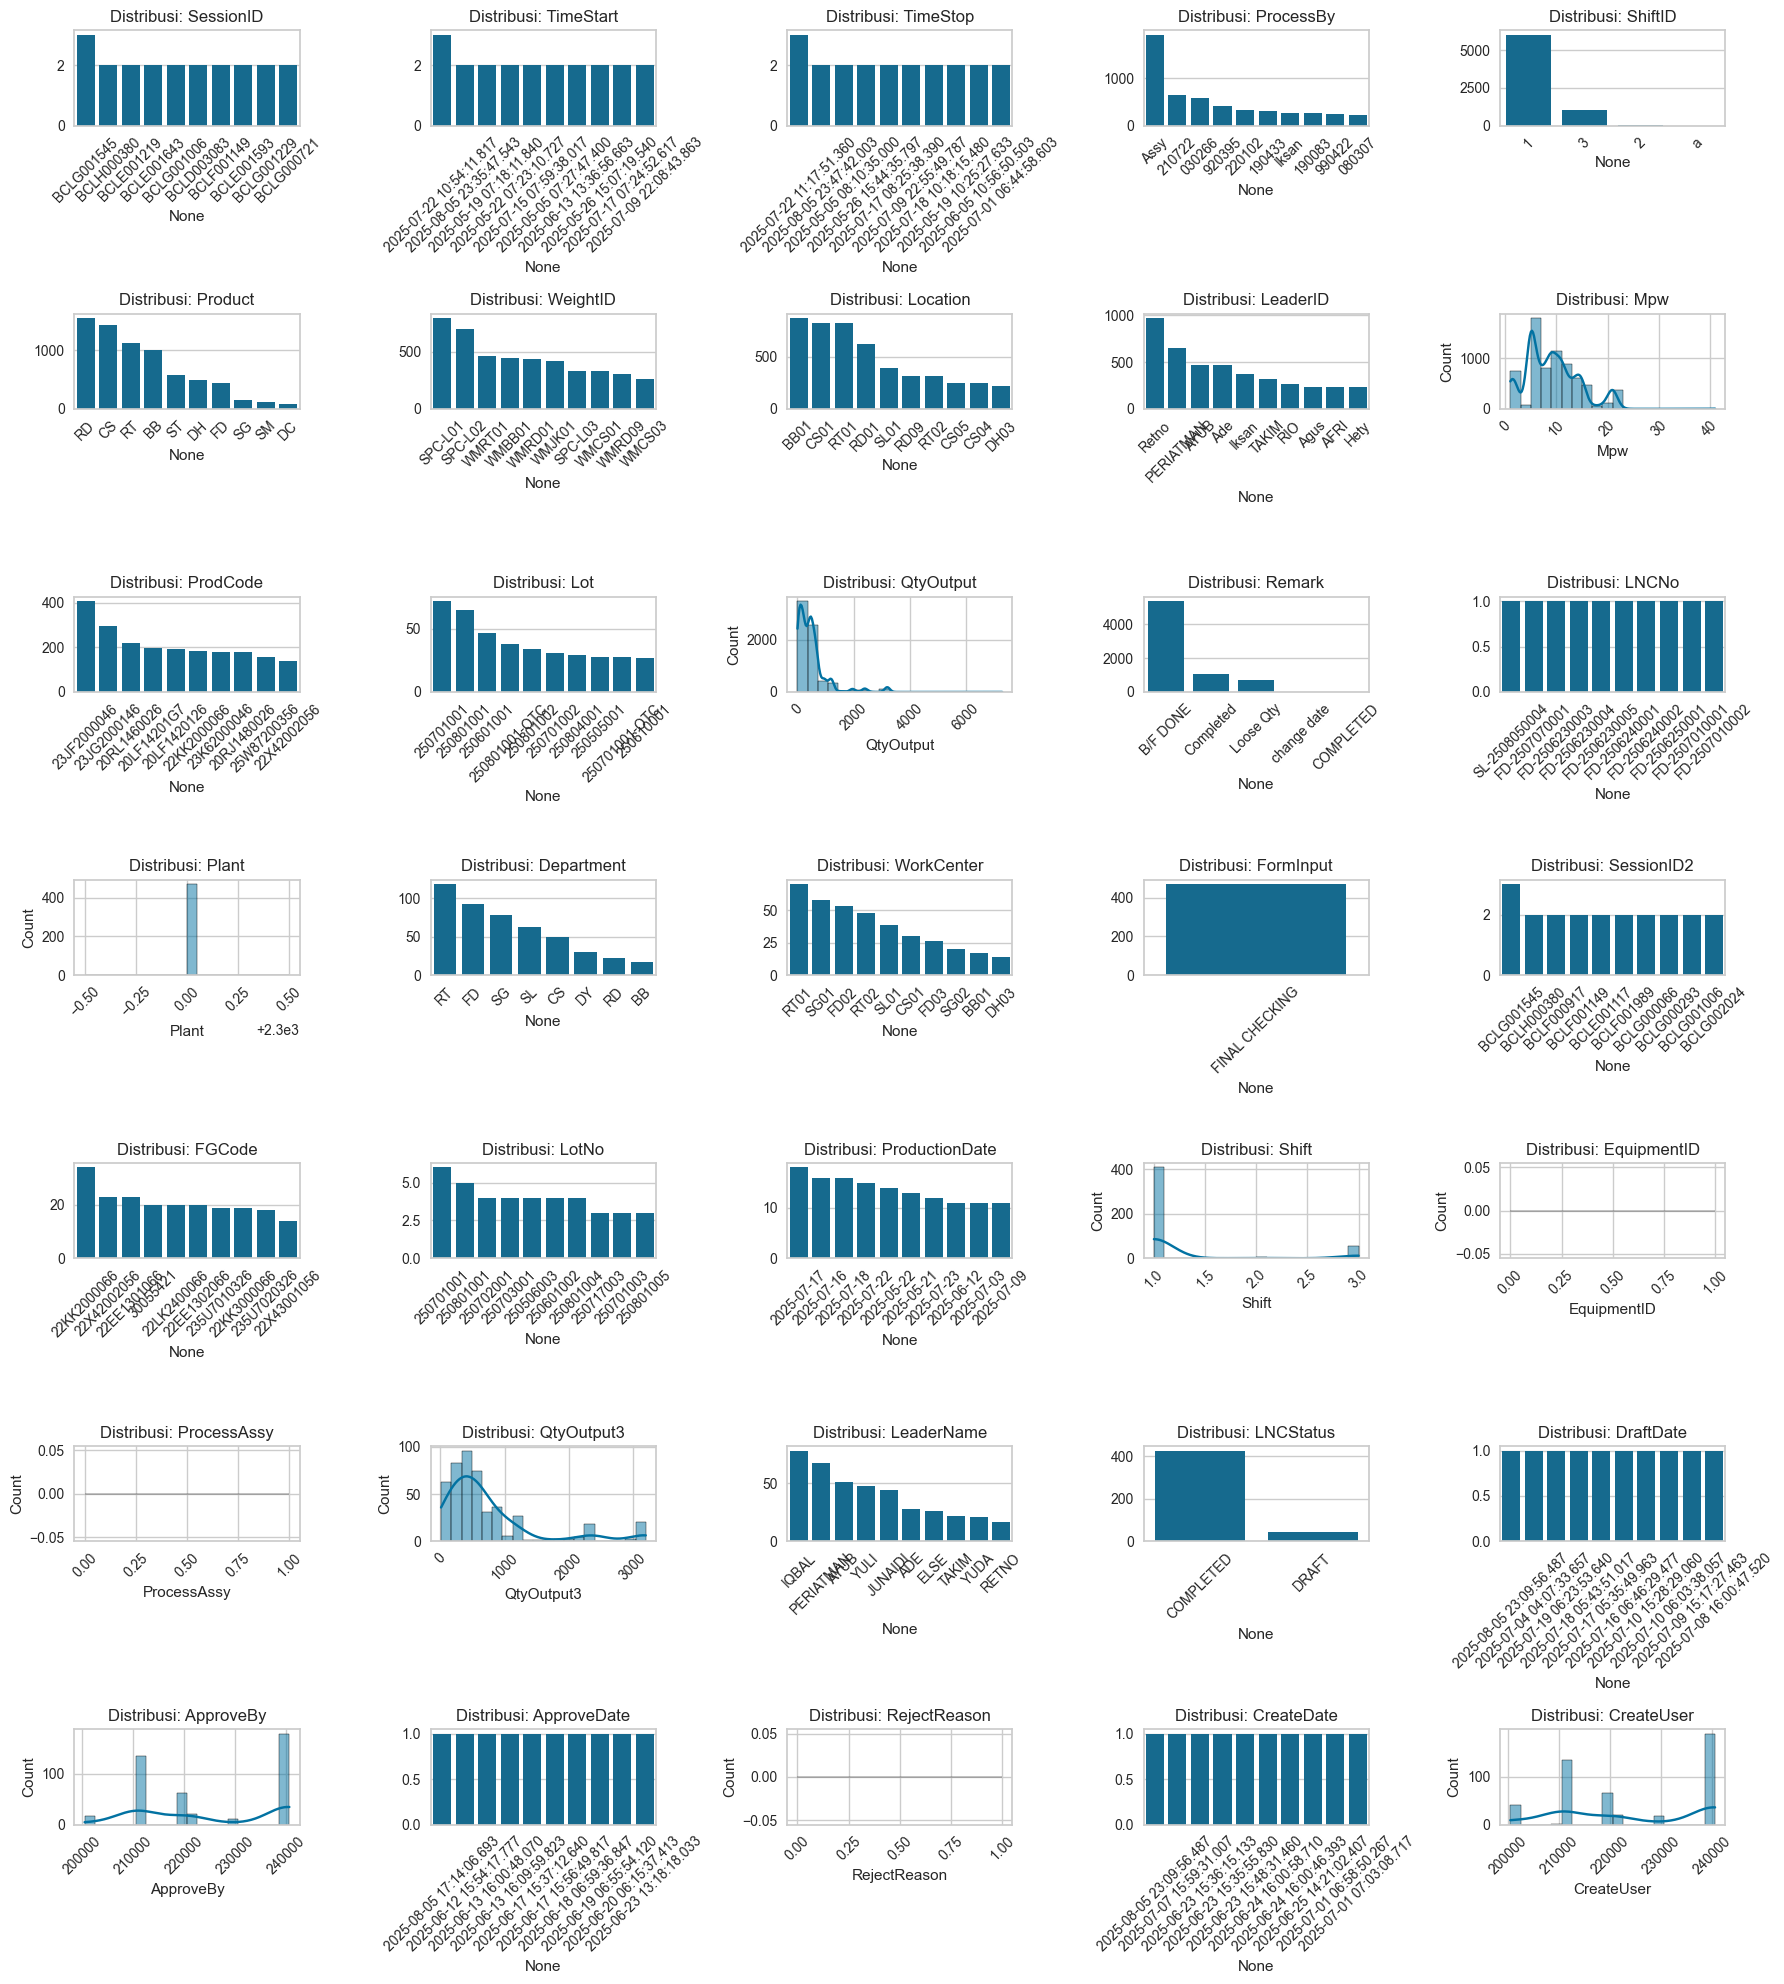

In [3]:

# Mengatur ukuran plot
plt.figure(figsize=(18, 20))

# Loop melalui setiap kolom untuk membuat visualisasi distribusi
for i, column in enumerate(df.columns, 1):
    plt.subplot(7, 5, i)
    
    # Kolom numerik
    if pd.api.types.is_numeric_dtype(df[column]):
        sns.histplot(df[column], kde=True, bins=20)
        plt.title(f"Distribusi: {column}")
        plt.xticks(rotation=45)
    
    # Kolom kategorikal
    elif pd.api.types.is_string_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
        top_10 = df[column].value_counts().nlargest(10)
        sns.barplot(x=top_10.index, y=top_10.values)
        plt.title(f"Distribusi: {column}")
        plt.xticks(rotation=45)
    
    # Kolom tanggal
    elif pd.api.types.is_datetime64_any_dtype(df[column]):
        if df[column].notna().any():
            date_dist = df[column].dt.floor('D').value_counts().sort_index()
            sns.lineplot(x=date_dist.index, y=date_dist.values)
            plt.title(f"Distribusi: {column}")
            plt.xticks(rotation=45)
        else:
            plt.title(f"Kolom: {column} (Semua NaT)")
    
    plt.tight_layout()

plt.show()

#### **2.2. Cleaning Data**

In [4]:

def clean_data(df):
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
   
    # Derive column 'isNC' from column: 'LNCNo'
    # check if LNCNo is null, empty, or "null" (case insensitive)
    def isNC(LNCNo):
        if pd.isnull(LNCNo) or str(LNCNo).strip() == "" or str(LNCNo).strip().lower() == "null":
            return 0
        # if not return as 1 or NC
        return 1
    
    df["isNC"] = df["LNCNo"].apply(isNC)
    
    # fill missing values for time columns
    df = (
        df
        .fillna({'TimeStop': df['TimeStop'].ffill()})
        .fillna({'TimeStart': df['TimeStart'].ffill()})
        .fillna({'ApproveDate': df['ApproveDate'].ffill()})
        .fillna({'CreateDate': df['CreateDate'].ffill()})
        .fillna({'ProductionDate': df['ProductionDate'].ffill()})
    )

       # Pastikan kolom tanggal sudah benar-benar dalam format datetime
    df['ApproveDate'] = pd.to_datetime(df['ApproveDate'], errors='coerce')
    df['CreateDate'] = pd.to_datetime(df['CreateDate'], errors='coerce')
    df['TimeStart'] = pd.to_datetime(df['TimeStart'], errors='coerce')
    df['TimeStop'] = pd.to_datetime(df['TimeStop'], errors='coerce')
    df['ProductionDate'] = pd.to_datetime(df['ProductionDate'], errors='coerce')

    # Membuat kolom-kolom dengan tipe data yang konsisten
    df['SessionID2'] = df['SessionID2'].apply(lambda x: str(x) if pd.notna(x) else "unknown")
    df['LNCStatus'] = df['LNCStatus'].apply(lambda x: str(x) if pd.notna(x) else "unknown")
    df['Product'] = df['Product'].apply(lambda x: str(x) if pd.notna(x) else "unknown")
    df['ApproveBy'] = df['ApproveBy'].fillna("unknown")
    df['CreateUser'] = df['CreateUser'].fillna("unknown")
    df['Department'] = df['Department'].fillna("unknown")
    df['WorkCenter'] = df['WorkCenter'].fillna("unknown")
    df['FGCode'] = df['FGCode'].fillna("unknown")
    df['LotNo'] = df['LotNo'].fillna("unknown")
    df['Shift'] = df['Shift'].fillna("unknown")
    df['LeaderName'] = df['LeaderName'].fillna("unknown")

    
    # Drop columns: indicate data leaks or not useful for create model
    df = df.drop(columns=[
        'QtyOutput3', 'ShiftID','SessionID2','Plant',
        'DraftDate', 'RejectReason', 'ProcessAssy', 
        'EquipmentID', 'FormInput', 'LNCNo']
        )

    # Change column type to string for columns: 'CreateUser', 'ApproveBy' and 2 other columns
    df = df.astype({'CreateUser': 'string', 'ApproveBy': 'string'})

    # rename columns
    df = df.rename(columns={'Mpw' : 'Man Power', 'QtyOutput': 'Qty'})

    return df

df_clean = clean_data(df)
# drop rows where ApproveDate is still NaT 
df_clean = df_clean[~df_clean['ApproveDate'].isna()]

df_clean.head()

,SessionID,TimeStart,TimeStop,ProcessBy,Product,WeightID,Location,LeaderID,Man Power,ProdCode,...,LotNo,ProductionDate,Shift,LeaderName,LNCStatus,ApproveBy,ApproveDate,CreateDate,CreateUser,isNC
1,BCLH000380,2025-08-05 23:35:47.543,2025-08-05 23:47:42.003,230302,ST,WMSL01,SL01,ELSE,11,30055421,...,250805010,2025-08-05,1.0,YUSUF,COMPLETED,220596.0,2025-08-05 17:14:06.693,2025-08-05 17:14:06.693,220596.0,1
2,BCLH000169,2025-08-05 11:21:39.053,2025-08-05 12:02:15.893,920395,ST,WMJK01,SL01,YUSUF,2,30055423,...,250804006,2025-08-04,1.0,YUSUF,COMPLETED,220596.0,2025-08-04 17:13:54.677,2025-08-04 17:13:54.677,220596.0,1
3,BCLG002388,2025-08-01 10:03:30.380,2025-08-01 10:13:43.553,920395,ST,WMJK01,SL01,ELSE,2,30055421,...,250801004,2025-08-01,1.0,ELSE,COMPLETED,220596.0,2025-08-02 06:53:20.893,2025-08-02 06:53:20.893,220596.0,1
4,BCLH000018,2025-08-04 16:12:00.200,2025-08-04 16:31:53.787,920395,ST,WMJK01,SL06,YUDA,2,20VT10000D6,...,250801001,2025-08-01,1.0,YUDA,COMPLETED,220534.0,2025-08-01 16:14:58.287,2025-08-01 16:14:58.280,220534.0,1
5,BCLG002412,2025-08-04 11:32:03.930,2025-08-04 11:42:32.303,920395,ST,WMJK01,SL01,YUSUF,2,30055421,...,250801005,2025-07-31,1.0,YUSUF,COMPLETED,220596.0,2025-08-01 06:46:09.520,2025-08-01 06:46:09.520,220596.0,1


In [5]:
df_clean.isnull().sum()

SessionID         0
TimeStart         0
TimeStop          0
ProcessBy         0
Product           0
WeightID          0
Location          0
LeaderID          0
Man Power         0
ProdCode          0
Lot               0
Qty               0
Remark            0
Department        0
WorkCenter        0
FGCode            0
LotNo             0
ProductionDate    0
Shift             0
LeaderName        0
LNCStatus         0
ApproveBy         0
ApproveDate       0
CreateDate        0
CreateUser        0
isNC              0
dtype: int64

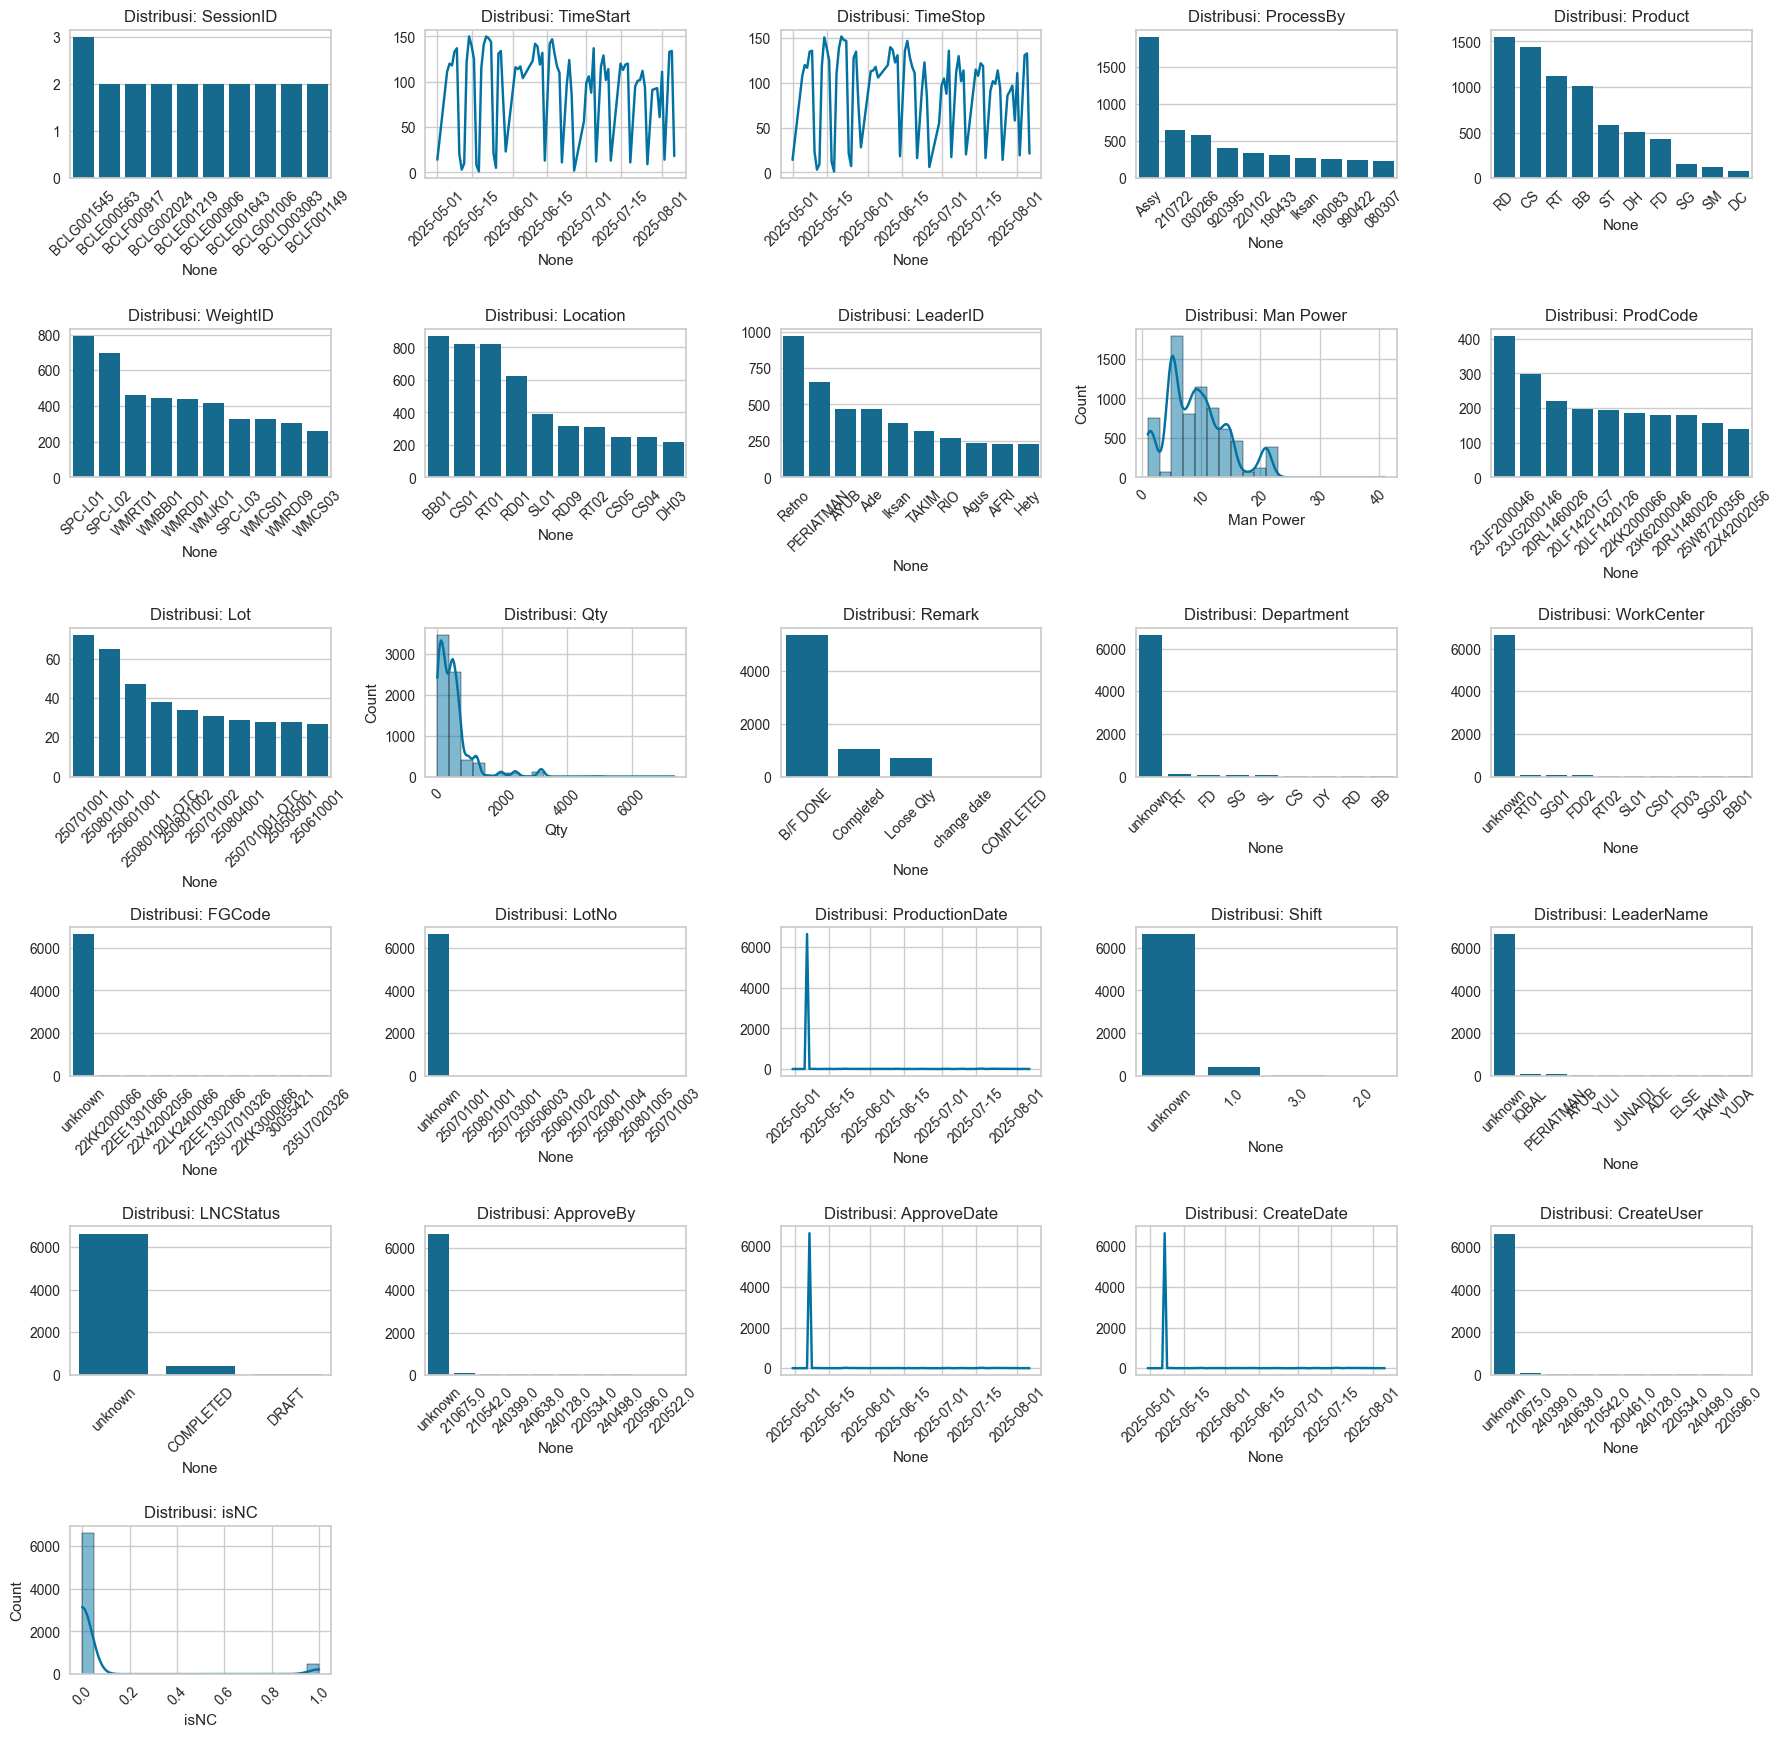

In [6]:

# Mengatur ukuran plot
plt.figure(figsize=(18, 20))

# Loop melalui setiap kolom untuk membuat visualisasi distribusi
for i, column in enumerate(df_clean.columns, 1):
    plt.subplot(7, 5, i)
    
    # Kolom numerik
    if pd.api.types.is_numeric_dtype(df_clean[column]):
        sns.histplot(df_clean[column], kde=True, bins=20)
        plt.title(f"Distribusi: {column}")
        plt.xticks(rotation=45)
    
    # Kolom kategorikal
    elif pd.api.types.is_string_dtype(df_clean[column]) or pd.api.types.is_object_dtype(df_clean[column]):
        top_10 = df_clean[column].value_counts().nlargest(10)
        sns.barplot(x=top_10.index, y=top_10.values)
        plt.title(f"Distribusi: {column}")
        plt.xticks(rotation=45)
    
    # Kolom tanggal
    elif pd.api.types.is_datetime64_any_dtype(df_clean[column]):
        if df_clean[column].notna().any():
            date_dist = df_clean[column].dt.floor('D').value_counts().sort_index()
            sns.lineplot(x=date_dist.index, y=date_dist.values)
            plt.title(f"Distribusi: {column}")
            plt.xticks(rotation=45)
        else:
            plt.title(f"Kolom: {column} (Semua NaT)")
    
    plt.tight_layout()

plt.show()

### **3. Setup & Training Model**

In [7]:
import pycaret
print(pycaret.__version__)

3.3.2


In [8]:
# Set up PyCaret environment with Random Oversampled data
clf = setup(
    data=df_clean,
    target='Man Power',
    session_id=123,
    normalize=True,
    remove_outliers=False,
    imputation_type='simple',
    transformation=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95
)

,Description,Value
0,Session id,123
1,Target,Man Power
2,Target type,Regression
3,Original data shape,"(7102, 26)"
4,Transformed data shape,"(7102, 117)"
5,Transformed train set shape,"(4971, 117)"
6,Transformed test set shape,"(2131, 117)"
7,Numeric features,2
8,Date features,5
9,Categorical features,18


In [9]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,1.3782,5.9330,2.4241,0.7783,0.2799,0.2799,0.2470
en,Elastic Net,2.8311,13.1258,3.6190,0.5091,0.4705,0.7062,0.2390
et,Extra Trees Regressor,3.7843,21.6394,4.6490,0.1895,0.5647,0.9085,0.3580
omp,Orthogonal Matching Pursuit,3.8897,23.6984,4.8657,0.1119,0.6104,1.0623,0.2330
br,Bayesian Ridge,3.9629,24.5669,4.9542,0.0793,0.6187,1.0869,0.2480
ridge,Ridge Regression,3.9657,24.6014,4.9577,0.0780,0.6190,1.0877,0.2260
huber,Huber Regressor,4.0014,24.9857,4.9957,0.0641,0.6198,1.0840,0.3910
par,Passive Aggressive Regressor,4.0622,25.8572,5.0824,0.0292,0.6265,1.1014,0.2380
lightgbm,Light Gradient Boosting Machine,4.0623,26.5908,5.1521,0.0052,0.6085,0.9955,0.4190
gbr,Gradient Boosting Regressor,4.0668,26.6624,5.1591,0.0025,0.6089,0.9959,0.3750


KNeighborsRegressor(n_jobs=-1)

In [10]:
# create model
knn_model = create_model('knn', cross_validation=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2647,5.4550,2.3356,0.7840,0.3022,0.3283
1,1.4596,8.4719,2.9106,0.7134,0.2554,0.1904
2,1.3203,4.5955,2.1437,0.8226,0.2544,0.2593
3,1.4849,6.7272,2.5937,0.7533,0.3065,0.3195
4,1.3586,5.2905,2.3001,0.7877,0.2939,0.2943
5,1.3211,5.2479,2.2908,0.7971,0.2812,0.2859
6,1.4346,5.6365,2.3741,0.8226,0.2462,0.2290
7,1.3050,5.2434,2.2898,0.7861,0.2819,0.2929
8,1.3167,4.9595,2.2270,0.8063,0.2786,0.2852


In [11]:
tuned_knn = tune_model(knn_model,
                       n_iter=10,
                       optimize='MAE',
                       search_library='optuna',
                       choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0890,4.0909,2.0226,0.8380,0.2890,0.3100
1,1.1654,6.1807,2.4861,0.7909,0.2379,0.1847
2,1.0741,3.4165,1.8484,0.8681,0.2576,0.2615
3,1.2332,4.5124,2.1242,0.8345,0.2958,0.3176
4,1.2040,4.1325,2.0329,0.8342,0.2796,0.2808
5,1.1026,3.5544,1.8853,0.8625,0.2757,0.2932
6,1.1482,3.5842,1.8932,0.8872,0.2283,0.2141
7,1.1526,4.3070,2.0753,0.8243,0.2801,0.2895
8,1.1107,3.7216,1.9291,0.8547,0.2769,0.2924


In [14]:
# plot model
plot_model(tuned_knn, plot='residuals',scale=2, save=True)

'Residuals.png'